## Project 5: Contagion risk mapper
**Goal**:
Simulate infection spread using symptom onset and contact logs — and flag crew members who had close contact with a symptomatic individual in the days leading up to their symptom onset.

### 1. Case identification

In [1]:
import pandas as pd

In [59]:
contagion_log = pd.read_csv('./data/contagion_log.csv')

In [3]:
contagion_log.head()

,date,crew_member,contact_with,symptoms
0,2025-03-20,Alice Carter,Ben O'Hara,No
1,2025-03-20,Ben O'Hara,Alice Carter,No
2,2025-03-20,Jonas Müller,Nina Patel,No
3,2025-03-20,Nina Patel,Leo Zhang,No
4,2025-03-20,Leo Zhang,Nina Patel,No


In [4]:
symptomatic = contagion_log[contagion_log['symptoms'] == 'Yes']

In [5]:
symptomatic

,date,crew_member,contact_with,symptoms
45,2025-03-27,Nina Patel,Leo Zhang,Yes
47,2025-03-27,Emma López,Alice Carter,Yes


On 2025-03-27, both:
- Nina Patel
- Emma López

became symptomatic (symptoms == "Yes"). This can be regarded as Day 0 for potential transmission.

### 2. Backward tracing - identifying suspected Source contacts
Purpose:
- Identify the source of the infection
- Understand the epidemiological chain
- Based on: who the symptomatic person was in contact with before symptoms

What happened before Nina Patel and Emma López became symptomatic?
Did one infect the other — or could other crew members have served as potential pre-symptomatic sources or amplifiers within the transmission chain, despite not exhibiting symptoms themselves?

Below we look at Nina Patel and Emma López's contact events in the 3 days before symptom onset, to identify individuals who may have contributed to the spread of infection through close proximity or repeated interactions.

In [6]:
def contact_tracing(names):
    for name in names:
        filter_name = contagion_log[contagion_log['crew_member']== name]
        filter_name = filter_name[(filter_name['date'] >= '2025-03-24') & (filter_name['date'] <='2025-03-26')]
        print(f"\n{filter_name}")

In [7]:
contact_tracing(['Nina Patel','Emma López'])


          date crew_member  contact_with symptoms
27  2025-03-24  Nina Patel  Alice Carter       No
33  2025-03-25  Nina Patel  Jonas Müller       No
39  2025-03-26  Nina Patel    Emma López       No

          date crew_member  contact_with symptoms
29  2025-03-24  Emma López  Alice Carter       No
35  2025-03-25  Emma López    Ben O'Hara       No
41  2025-03-26  Emma López  Jonas Müller       No


- Nina Patel had contact with Emma López **one day** before **both** became symptomatic.
- **Both** had contact with **Alice Carter 3 days before** symptom onset.
- **Both** had contact with **Jonas Müller** before symptom onset, albeit on different days.

#### Possible interpretations:
1. Possible transmission path from Emma López to Nina Patel (i.e., Emma López infected Nina Patel).
2. Alice Carter was contacted by both symptomatic individulas on the same day, suggesting that she may serve as a **central node** in the contact network.
3. Jonas Müller has separate direct contact with both prior to their symptom onset, placing him in a position of **epidemiological interest**.
   
Although neither has shown symptoms, Alice and Jonas' repeated appearance in exposure chains warrants further investigation to determine whether they acted as asymptomatic spreaders, intermediaries, or were simply coincidental contacts.

In [8]:
# Tracing Alice Carter and Jonas Müller's contacts before 24th
def contact(names):
    for name in names:
        contact = contagion_log[contagion_log['crew_member'] == name]
        contact = contact[contact['date'] < '2025-03-27']
        print(contact)

In [9]:
contact(['Alice Carter','Jonas Müller'])

          date   crew_member  contact_with symptoms
0   2025-03-20  Alice Carter    Ben O'Hara       No
6   2025-03-21  Alice Carter    Ben O'Hara       No
12  2025-03-22  Alice Carter     Leo Zhang       No
18  2025-03-23  Alice Carter           NaN       No
24  2025-03-24  Alice Carter  Jonas Müller       No
30  2025-03-25  Alice Carter    Nina Patel       No
36  2025-03-26  Alice Carter     Leo Zhang       No
          date   crew_member  contact_with symptoms
2   2025-03-20  Jonas Müller    Nina Patel       No
8   2025-03-21  Jonas Müller    Emma López       No
14  2025-03-22  Jonas Müller    Emma López       No
20  2025-03-23  Jonas Müller     Leo Zhang       No
26  2025-03-24  Jonas Müller           NaN       No
32  2025-03-25  Jonas Müller  Alice Carter       No
38  2025-03-26  Jonas Müller    Ben O'Hara       No


#### Contact patterns observed
Both Nina and Emma had contact with **Jonas Müller and Alice Carter** between 2025-03-24 and 2025-03-26.

Specifically:
- Nina contacted Jonas on 2025-03-25
- Emma contacted Jonas on 2025-03-26
- Both contacted Alice Carter on 2025-03-24

#### Contact logs for Jonas Müller:
- Jonas contacted Nina (as early as 2025-03-20)Emma (2025-03-21 & 22)
- Jonas was contacted by Alice Carter on 2025-03-24
- Jonas has not reported any symptoms to date

#### Contact logs for Alice Carter:
- Alice was in contact with Ben, Jonas, Leo, and Nina between 2025-03-20 and 2025-03-26
- She was also contacted by both symptomatic individuals on 2025-03-24
- Alice is also not symptomatic, but frequently present in multiple contact chains

### Interpretation & preliminary conclusion
Jonas Müller is the most likely common point of exposure:
- He had earlier contact with both Nina and Emma than any other crew member.
- His interactions fall within plausible incubation windows.
- He has not shown symptoms, suggesting possible asymptomatic transmission.

Alice Carter appears frequently in contact chains and was in touch with both symptomatic crew on the same day (2025-03-24), the only shared exposure date. This positions her as a possible intermediary.

While a definitive transmission source cannot be confirmed without clinical testing, the contact patterns suggest that both Jonas and Alice played key roles in the potential spread. They should be treated as **epidemiologically significant contacts** and monitored accordingly.


### 3. Forward tracing - identifying who might get infected next
Purpose:
- Prevent further spread
- Quarantine or monitor exposed individuals
- Based on: who the symptomatic person contacted before onset

In [10]:
from datetime import datetime
from datetime import timedelta

In [11]:
date_new = []
for d in contagion_log['date']:
    date_obj = datetime.strptime(d, "%Y-%m-%d").date()
    date_new.append(date_obj)
contagion_log['date_new'] = date_new
contagion_log.head()

,date,crew_member,contact_with,symptoms,date_new
0,2025-03-20,Alice Carter,Ben O'Hara,No,2025-03-20
1,2025-03-20,Ben O'Hara,Alice Carter,No,2025-03-20
2,2025-03-20,Jonas Müller,Nina Patel,No,2025-03-20
3,2025-03-20,Nina Patel,Leo Zhang,No,2025-03-20
4,2025-03-20,Leo Zhang,Nina Patel,No,2025-03-20


In [12]:
def contact_chain(names):
    for name in names:
        symptomatic = contagion_log[(contagion_log['crew_member'] == name) & (contagion_log['symptoms'] == 'Yes')]
        date_symp = symptomatic['date_new'].values[0]
        recent_contact = contagion_log[(contagion_log['date_new'] >= date_symp -  timedelta(days=3)) & (contagion_log['date_new'] < date_symp) & (contagion_log['contact_with']==name)]
        print(recent_contact)

In [13]:
contact_chain(['Nina Patel','Emma López'])

          date   crew_member contact_with symptoms    date_new
30  2025-03-25  Alice Carter   Nina Patel       No  2025-03-25
31  2025-03-25    Ben O'Hara   Nina Patel       No  2025-03-25
37  2025-03-26    Ben O'Hara   Nina Patel       No  2025-03-26
          date crew_member contact_with symptoms    date_new
39  2025-03-26  Nina Patel   Emma López       No  2025-03-26


#### Interpretation:
- **Ben O’Hara** had multiple contacts with Nina in the possible infectious window and may be at elevated risk of exposure.
- Emma López was contacted by Nina one day before both became symptomatic — a possible mutual exposure or bidirectional transmission event.

### 4. Visualizing contagion connections

In [14]:
import networkx as nx
print(nx.__version__)

3.3


In [15]:
import matplotlib.pyplot as plt

In [16]:
# creating a graph
G = nx.DiGraph()

In [60]:
contagion_log.head()

,date,crew_member,contact_with,symptoms
0,2025-03-20,Alice Carter,Ben O'Hara,No
1,2025-03-20,Ben O'Hara,Alice Carter,No
2,2025-03-20,Jonas Müller,Nina Patel,No
3,2025-03-20,Nina Patel,Leo Zhang,No
4,2025-03-20,Leo Zhang,Nina Patel,No


In [62]:
contagion_log = contagion_log[contagion_log['date'] < '2025-03-27']
contagion_log.tail()

,date,crew_member,contact_with,symptoms
37,2025-03-26,Ben O'Hara,Nina Patel,No
38,2025-03-26,Jonas Müller,Ben O'Hara,No
39,2025-03-26,Nina Patel,Emma López,No
40,2025-03-26,Leo Zhang,NaN,No
41,2025-03-26,Emma López,Jonas Müller,No


In [63]:
for index, row in contagion_log.iterrows():
    source = row['crew_member']
    target = row['contact_with']
    #only add if contact_with is NOT NaN
    if pd.notnull(target):
        G.add_edge(source, target, date = row['date']) # store contact as edge

In [75]:
# styling the nodes so that it is easier to distinguish
node_colors = []
for node in G.nodes():
    if node in ['Nina Patel', 'Emma López']:
        node_colors.append('red')
    elif node in ["Ben O'Hara", "Alice Carter", "Jonas Müller"]:
        node_colors.append('orange')
    else:
        node_colors.append('yellow')
    

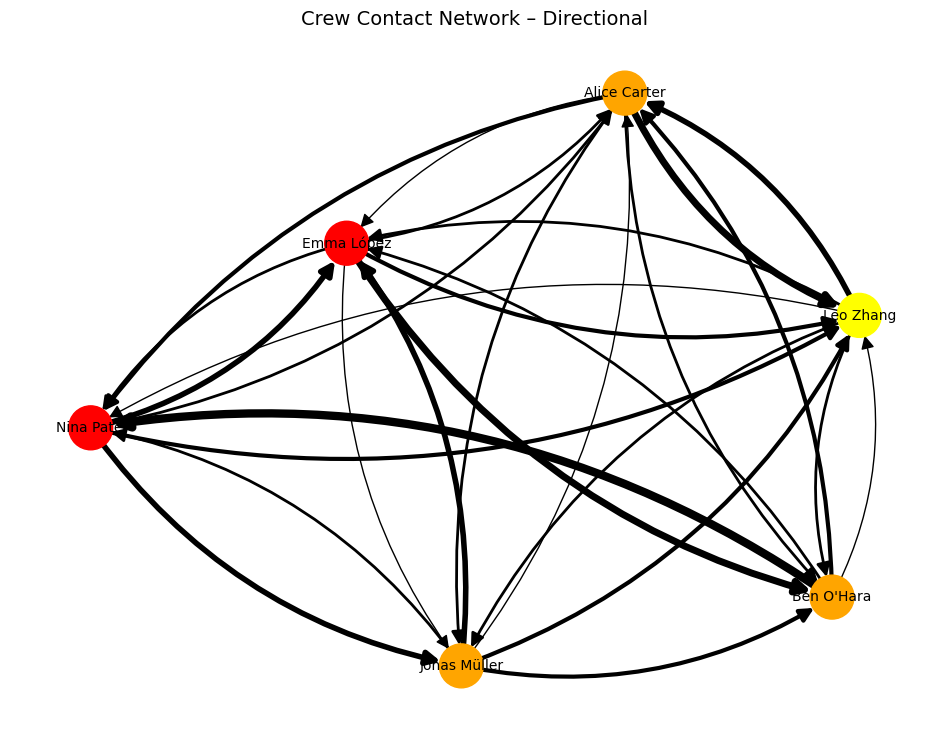

In [76]:
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42, k=1.5)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=10)

nx.draw_networkx_edges(
    G, pos,
    arrows=True,
    arrowstyle='-|>',            
    arrowsize=20,                
    connectionstyle='arc3,rad=0.2',
    width=edge_widths,
    min_target_margin=15         
)

plt.title("Crew Contact Network – Directional", fontsize=14)
plt.axis('off')
plt.show()

**NOTE:**
- Arrow thickness reflects contact frequency: **thicker arrows = more interactions**.
- Arrow direction indicates who initiated the contact.

| Crew Member     | Observed role based on graph                          | Interpretation & risk level                          |
|-----------------|--------------------------------------------------------|-------------------------------------------------------|
| **Nina Patel**   | Many thick arrows **pointing toward** her             | Likely exposed by multiple contacts; **symptomatic**      |
| **Emma López**   | Multiple arrows directed **toward** her, some thick   | Similar pattern to Nina; **symptomatic**                  |
| **Alice Carter** | Mix of outgoing and incoming arrows | **Bidirectional contact hub**, not clearly source or sink |
| **Ben O’Hara**   | Receives multiple thick arrows        | Active contact initiator; **high exposure risk**          |
| **Jonas Müller** | Thick outgoing arrows to symptomatic cases  | Consistent contact with both; remains a **strong candidate for pre-symptomatic transmission** |
| **Leo Zhang**    | Receives several arrows, limited initiation           | Lower centrality; passive monitoring appropriate       |


### 5. Crew monitoring recommendations:

| Crew Member   | Status                          | Justification                                                                 | Recommended Action                       |
|---------------|----------------------------------|--------------------------------------------------------------------------------|------------------------------------------|
| **Nina Patel**    | Symptomatic                      | Confirmed symptomatic on 2025-03-27                                             | 🔴 Isolate immediately                    |
| **Emma López**    | Symptomatic                      | Confirmed symptomatic on 2025-03-27                                             | 🔴 Isolate immediately                    |
| **Ben O’Hara**    | High-risk downstream contact     | Contacted Nina twice during her infectious window                               | 🟠 Active monitoring                      |
| **Alice Carter**  | Upstream contact / network hub   | Contacted by both Nina and Emma on 2025-03-24; central in multiple contact chains | 🟠 Active monitoring                      |
| **Jonas Müller**  | Upstream contact / likely source | Contact with both Nina and Emma prior to onset; no symptoms reported            | 🟠 Active monitoring                      |
| **Leo Zhang**     | Indirect exposure (x2)           | Contacted by Alice and Jonas within exposure window                             | 🟡 Passive monitoring (daily check-ins)   |


--THE END--